In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as sm

%matplotlib inline


## Reading Data

In [31]:
df = pd.read_csv("bus_data/cleaned_data/line46.csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "Direction", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Operator", "Congestion", "LonWGS84", "LatWGS84", 
              "Delay", "BlockID", "VehicleID", "StopID", "AtStop"]


In [3]:
df.shape


(3567679, 15)

In [4]:
df.dtypes

Timestamp             int64
LineID              float64
Direction             int64
JourneyPatternID     object
TimeFrame            object
VehicleJourneyID      int64
Operator             object
Congestion            int64
LonWGS84            float64
LatWGS84            float64
Delay                 int64
BlockID               int64
VehicleID             int64
StopID               object
AtStop                int64
dtype: object

## Cleaning Data

In [6]:
#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns


In [7]:
#Convert selected columns to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')   

In [8]:
# Convert some features to categorical
for column in ['LineID', 'VehicleJourneyID', 'Congestion', 'BlockID', 'VehicleID', 'AtStop']:
    df[column] = df[column].astype('category')

In [9]:
# Convert Unix timestamp to datetime

# Take uneccesary trailing zeroes off of unix timestamp. 
df['Timestamp'] = df['Timestamp'].apply(lambda x: x//1000000)

# Convert the timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')



In [10]:
# Add day of week column
df['Day'] = df['Timestamp'].dt.dayofweek

In [11]:
# Add hour of day column
df['Hour'] = df['Timestamp'].dt.hour

## Data Descriptions


In [32]:
df.head(10)

,Timestamp,LineID,Direction,JourneyPatternID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,StopID,AtStop
0,1352160000000000,46.0,0,046A1002,2012-11-05,7267,D2,0,-6.259093,53.345425,-1101,46004,36024,794,0
1,1352160004000000,46.0,0,046A1001,2012-11-05,7417,D2,0,-6.242417,53.326218,-413,46018,36019,804,0
2,1352160006000000,46.0,0,046A0001,2012-11-05,7254,D2,0,-6.195517,53.298882,0,46003,36025,2039,1
3,1352160008000000,46.0,0,046A0002,2012-11-05,7333,D2,0,-6.230650,53.317867,0,46010,36008,334,1
4,1352160010000000,46.0,0,00471001,2012-11-05,5401,D1,0,-6.224720,53.340553,-426,46020,33387,391,0
5,1352160010000000,46.0,0,046A0001,2012-11-05,7345,D2,0,-6.230783,53.317268,-1012,46011,36009,2035,0
6,1352160010000000,46.0,0,00470001,2012-11-05,5392,D1,0,-6.220209,53.258236,-825,46025,33526,3473,0
7,1352160012000000,46.0,0,046A0001,2012-11-05,7429,D1,0,-6.172080,53.274429,-89,46019,33540,2017,0
8,1352160023000000,46.0,0,046A1001,2012-11-05,7417,D2,0,-6.240850,53.325100,-413,46018,36019,804,0
9,1352160027000000,46.0,0,046A0001,2012-11-05,7254,D2,0,-6.199850,53.297733,0,46003,36025,2039,1


In [12]:
# Descriptive stats for categorical features
df.select_dtypes(['category']).describe().T

,count,unique,top,freq
LineID,3.56768e+06,1,46,3.56768e+06
JourneyPatternID,3567613,29,046A1001,1485024
TimeFrame,3567679,58,2012-11-23,77688
VehicleJourneyID,3567679,2997,6590,7326
Operator,3567679,8,D2,2269340
Congestion,3567679,2,0,3534258
BlockID,3567679,73,46010,166573
VehicleID,3567679,260,36010,94166
StopID,3567679,238,2039,349610
AtStop,3567679,2,0,2471883


In [13]:
# Descriptive stats for continuous features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Direction,3567679.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LonWGS84,3567679.0,-6.222446,0.052079,-6.387367,-6.260678,-6.230900,-6.182746,-6.100966
LatWGS84,3567679.0,53.319008,0.029663,53.181885,53.294632,53.319801,53.350033,53.423332
Delay,3567679.0,-144.848554,441.065986,-7632.000000,-362.000000,-71.000000,15.000000,8365.000000
Day,3567679.0,2.584571,1.786075,0.000000,1.000000,2.000000,4.000000,6.000000
Hour,3567679.0,13.869929,4.828944,0.000000,10.000000,14.000000,18.000000,23.000000


## Visualisations

In [14]:
df["Congestion"] = df[column].astype('int64')

In [15]:
categorical_features = ["LineID", "JourneyPatternID", "TimeFrame", "VehicleJourneyID", 
                       "Operator", "Congestion", "BlockID", "VehicleID", "StopID", "AtStop"]
continuous_features = ["Timestamp", "LonWGS84", "LatWGS84", "Delay", "Congestion"]

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text xticklabel objects>)

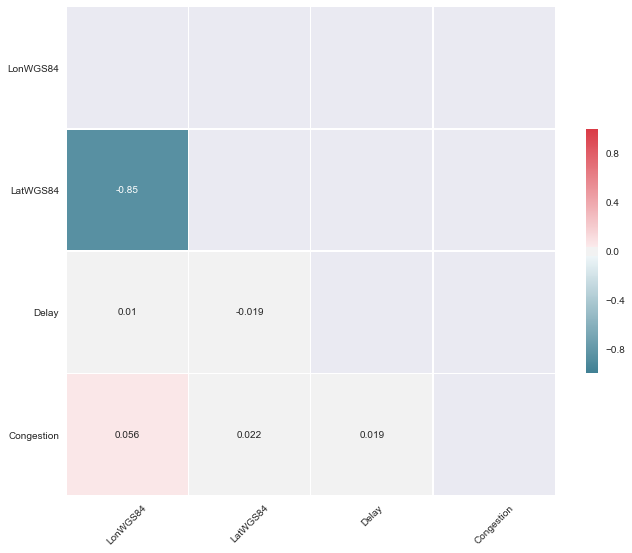

In [16]:
# Calculate correlation of all pairs of continuous features
corr = df[continuous_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

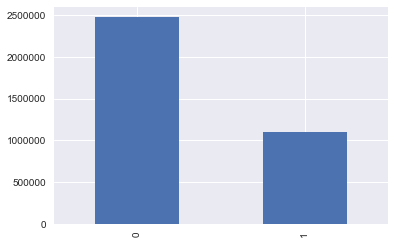

In [19]:
df['Congestion'].value_counts().plot(kind='bar')

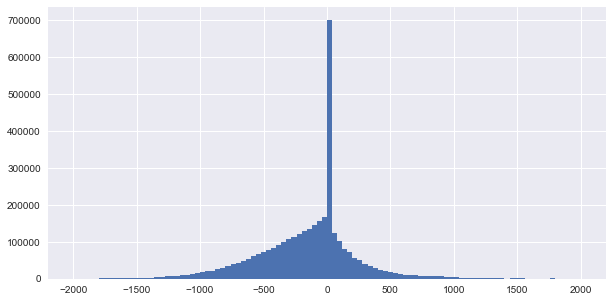

In [20]:
df["Delay"].hist(figsize=(10, 5), bins=100, range=[-2000, 2000])

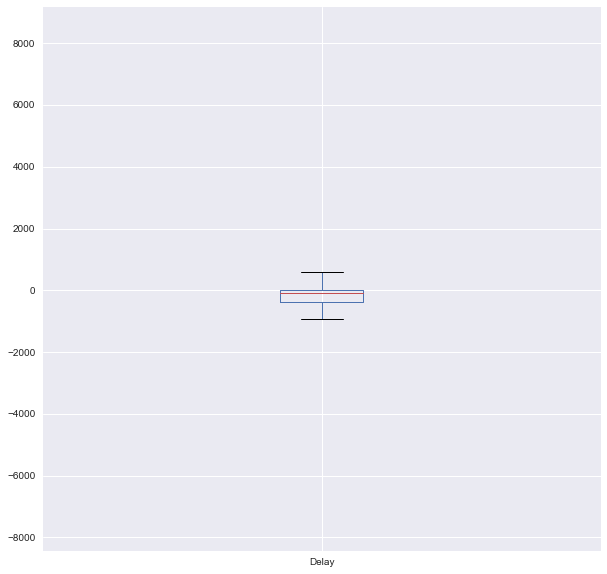

In [21]:
plt.figure(figsize=(10, 10))
df["Delay"].plot(kind='box')

In [24]:
groups = df.groupby([df["Timestamp"].dt.dayofweek, df["Timestamp"].dt.hour])["Delay"].mean()

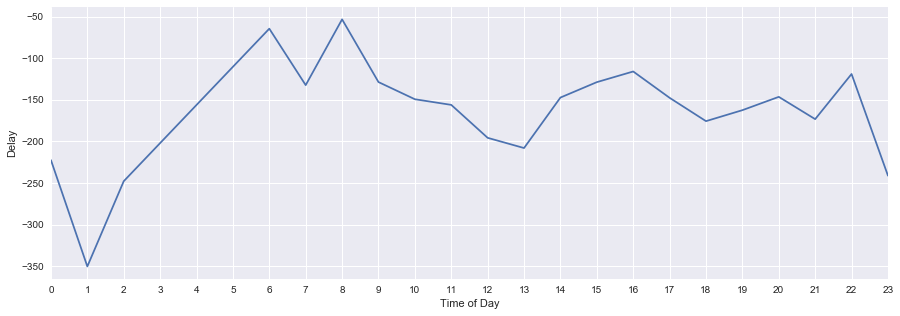

In [26]:
hourly_delay = df.groupby(['Hour'])["Delay"].mean().plot(figsize=(15,5))

hourly_delay.set(xlabel="Time of Day", ylabel="Delay")
hourly_delay.set_xticks([x for x in range(24)])
hourly_delay.set_xticklabels([x for x in range(24)])

[<matplotlib.text.Text at 0x118476be0>, <matplotlib.text.Text at 0x1184ae7f0>]

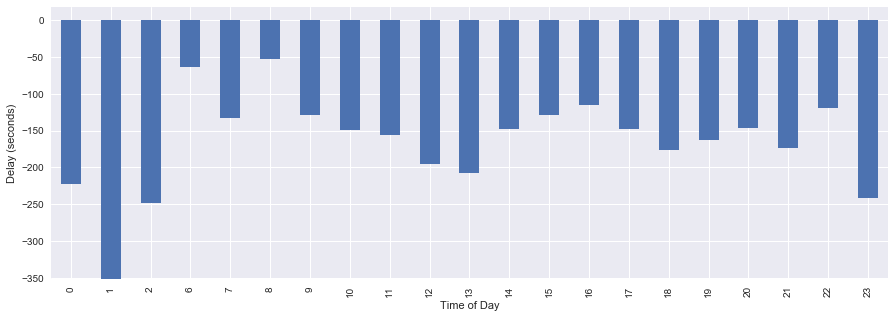

In [27]:
hourly_delay = df.groupby(['Hour'])["Delay"].mean().plot(figsize=(15,5), kind='bar')

hourly_delay.set(xlabel="Time of Day", ylabel="Delay (seconds)")

# plt.savefig("hourly_delay_bar.png")

In [28]:
days = df.groupby(["Day"])


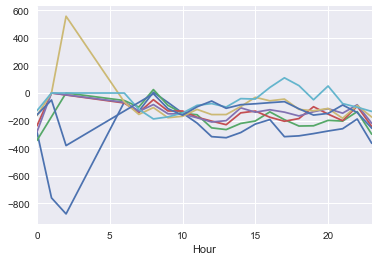

In [38]:
for key, day in days:
    
    hours = day.groupby(["Hour"])["Delay"].mean().plot()
